In [ ]:
import sys
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np

%matplotlib notebook


In [46]:
########################################################################
## Base Classes and Functions for Data Handling ##
## (Originally in the first code block.) ##
##################################################
class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
        self.timeRpt = []; self.tempRpt = []
        self.axRpt = []; self.ayRpt = []; self.azRpt = []
        self.mxRpt = []; self.myRpt = []; self.mzRpt = []
        self.gxRpt = []; self.gyRpt = []; self.gzRpt = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
        self.timeRpt = []
        self.pip0Rpt = []; self.pip1Rpt = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    
    dataSet.imu.axRpt = dataSet.imu.axRpt.tolist()
    dataSet.imu.ayRpt = dataSet.imu.ayRpt.tolist()
    dataSet.imu.azRpt = dataSet.imu.azRpt.tolist()
    dataSet.imu.mxRpt = dataSet.imu.mxRpt.tolist()
    dataSet.imu.myRpt = dataSet.imu.myRpt.tolist()
    dataSet.imu.mzRpt = dataSet.imu.mzRpt.tolist()
    dataSet.imu.gxRpt = dataSet.imu.gxRpt.tolist()
    dataSet.imu.gyRpt = dataSet.imu.gyRpt.tolist()
    dataSet.imu.gzRpt = dataSet.imu.gzRpt.tolist()
    dataSet.imu.tempRpt = dataSet.imu.tempRpt.tolist()
    dataSet.imu.timeRpt = dataSet.imu.timeRpt.tolist()
    dataSet.sweeps.timeRpt = dataSet.sweeps.timeRpt.tolist()
    dataSet.sweeps.pip0Rpt = dataSet.sweeps.pip0Rpt.tolist()
    dataSet.sweeps.pip1Rpt = dataSet.sweeps.pip1Rpt.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()
    
# Functions for padding data

# padding time data as lists
def timefix(l, new, dt):   # l = time data as list, new = empty list, dt = delta t
    for t in l:
        if l.index(t) >= 2:
            # replace bad timewords
            if t - l[l.index(t) - 1] < 0 or t - l[l.index(t) - 1] > 1:
                l[l.index(t) - 1] = l[l.index(t) - 2] + dt
                t = l[l.index(t) - 1] + dt
            # if more than delta_t gap, fill in
            elif t - l[l.index(t) - 1] >= 2 * dt:
                new.append(l.index(t))
                l.insert(l.index(t), l[l.index(t) - 1] + dt)

# running through timewords and cleaning all mistakes from timefix
def clean(l, dt):    # l = same l data from timefix, dt = delta t
    i = 2
    cnt=0
    while i < len(l):
        if l[i] - l[i - 1] < 0 or l[i] - l[i - 1] > 1:
            l[i] = l[i - 1] + dt
            #Debugging
            #cnt += 1
            #print("Had to change!")
        else:
            i += 1
            #Debugging
            #cnt=0
        #Debugging
        #if cnt % 100000000 is 0 and cnt is not 0: print('Over %s loops for %s (i=%s)' %(cnt,l[i],i))

# padding pip data as arrays
def pad_data(original, new):  # original = non-time data array, new = same "new" list (now filled) from timefix
    NaN = np.nan
    if original is pip0 or original is pip1 or original is pip0Rpt or original is pip1Rpt:
        filler = np.full([1,28], NaN)
    else:
        filler = np.full([1,1], NaN)
    for data in new:
        one = np.split(original, [data])[0]
        two = np.split(original, [data])[1]
        original = np.vstack((one, filler, two))
    return original
########################################################################

########################################################################
## New Classes and Functions for Data Handling Based on Old Code##
##################################################################
########### Load the data file ###########
def load_data_file(dataFile, strict_parse=True, echo=True):
    """
    Load data from file into payloads list of payload objects. 
    (Originally the second code block in notebook.)
    
    Parameters 
    -----------
    dataFile : File path for the data file 
    strict_parse : (Defalut: True) Require a pound symbol at the end of the data
    
    Returns
    --------
    payloads: List of payload objects
    interruptTime: Event Interrupt array.
    """
    f = open(dataFile, 'r')
    rawData = f.read()

    # Create payload objects and store parsed data
    mainPIPData = PayloadData()
    mainPIPData.rawData = rawData
    payloads = [mainPIPData]

    ########### Parse by data type for each payload ###########
    for payload in payloads:
        payloadrawData = payload.rawData
        imu = []
        sweeps = []
        imuRpt = []
        sweepsRpt = []
        interrupt = []
        # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
        sweepSamples = 28
        numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
        # 9 2-byte data points + 2-byte temp + 4-byte timestamp
        numIMUBytes = 24
        # Barium interrupt
        numInterruptBytes = 4

        pntr = 0
        while pntr < len(payloadrawData):
            # Check message start sentinels and not at end
            if payloadrawData[pntr] == '#' and (len(payloadrawData)-pntr) >= numIMUBytes:
                if payloadrawData[pntr+1] == 'I':
                    # If not the last, check message end sentinel
                    if pntr+2+numIMUBytes < len(payloadrawData):
                        if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                            imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                    # Or just add the last message
                    else:
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                    pntr += 1
                elif payloadrawData[pntr+1] == 'S':
                    if  pntr+2+numSweepBytes < len(payloadrawData):
                        if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                            sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                    else:
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                    pntr += 1
                elif payloadrawData[pntr+1] == 'J':
                    if pntr+2+numIMUBytes < len(payloadrawData):
                        if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                            imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                    else:
                        imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                    pntr += 1
                elif payloadrawData[pntr+1] == 'T':
                    if  pntr+2+numSweepBytes < len(payloadrawData):
                        if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                            sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                    else:
                        sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                    pntr += 1
                elif payloadrawData[pntr+1] == 'B':
                    if  pntr+2+numInterruptBytes < len(payloadrawData):
                        if not strict_parse or payloadrawData[pntr+2+numInterruptBytes] == '#':
                            interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                    else:
                        interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                    pntr += 1
                else:
                    pntr += 1
            else:
                pntr += 1
        if echo:
            print("Num IMU Messages: %s" %len(imu))
            print("Num Sweep Messages: %s" %len(sweeps))
            print("Num IMU Messages (buffer): %s" %len(imuRpt))
            print("Num Sweep Messages (buffer): %s" %len(sweepsRpt))
            print("Num interrupt messages: %s" %len(interrupt))

        ########### Build data structures ###########
        # First the IMU/IMU Buffer
        imuTime = [];
        ax = []; ay = []; az = []
        mx = []; my = []; mz = []
        gx = []; gy = []; gz = []
        temp = [];

        imuTimeRpt = [];
        axRpt = []; ayRpt = []; azRpt = []
        mxRpt = []; myRpt = []; mzRpt = []
        gxRpt = []; gyRpt = []; gzRpt = []
        tempRpt = [];

        for i in imu:
            if len(i) == numIMUBytes:
                imuTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                # The byte order is reversed, but the data sets are not
                ax.append(combine2(ord(i[5]), ord(i[4])))
                ay.append(combine2(ord(i[7]), ord(i[6])))
                az.append(combine2(ord(i[9]), ord(i[8])))
                mx.append(combine2(ord(i[11]), ord(i[10])))
                my.append(combine2(ord(i[13]), ord(i[12])))
                mz.append(combine2(ord(i[15]), ord(i[14])))
                gx.append(combine2(ord(i[17]), ord(i[16])))
                gy.append(combine2(ord(i[19]), ord(i[18])))
                gz.append(combine2(ord(i[21]), ord(i[20])))
                temp.append(combine2(ord(i[23]), ord(i[22])))

        for i in imuRpt:
            if len(i) == numIMUBytes:
                imuTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                axRpt.append(combine2(ord(i[5]), ord(i[4])))
                ayRpt.append(combine2(ord(i[7]), ord(i[6])))
                azRpt.append(combine2(ord(i[9]), ord(i[8])))
                mxRpt.append(combine2(ord(i[11]), ord(i[10])))
                myRpt.append(combine2(ord(i[13]), ord(i[12])))
                mzRpt.append(combine2(ord(i[15]), ord(i[14])))
                gxRpt.append(combine2(ord(i[17]), ord(i[16])))
                gyRpt.append(combine2(ord(i[19]), ord(i[18])))
                gzRpt.append(combine2(ord(i[21]), ord(i[20])))
                tempRpt.append(combine2(ord(i[23]), ord(i[22])))

        imuTime = np.array(imuTime, dtype='uint32')
        ax = np.array(ax, dtype='int16')
        ay = np.array(ay, dtype='int16')
        az = np.array(az, dtype='int16')
        mx = np.array(mx, dtype='int16')
        my = np.array(my, dtype='int16')
        mz = np.array(mz, dtype='int16')
        gx = np.array(gx, dtype='int16')
        gy = np.array(gy, dtype='int16')
        gz = np.array(gz, dtype='int16')
        temp = np.array(temp, dtype='int16')

        imuTimeRpt = np.array(imuTimeRpt, dtype='uint32')
        axRpt = np.array(axRpt, dtype='int16')
        ayRpt = np.array(ayRpt, dtype='int16')
        azRpt = np.array(azRpt, dtype='int16')
        mxRpt = np.array(mxRpt, dtype='int16')
        myRpt = np.array(myRpt, dtype='int16')
        mzRpt = np.array(mzRpt, dtype='int16')
        gxRpt = np.array(gxRpt, dtype='int16')
        gyRpt = np.array(gyRpt, dtype='int16')
        gzRpt = np.array(gzRpt, dtype='int16')
        tempRpt = np.array(tempRpt, dtype='int16')

        payload.imu.time = imuTime
        payload.imu.ax = ax
        payload.imu.ay = ay
        payload.imu.az = az
        payload.imu.mx = mx
        payload.imu.my = my
        payload.imu.mz = mz
        payload.imu.gx = gx
        payload.imu.gy = gy
        payload.imu.gz = gz
        payload.imu.temp = temp

        payload.imu.timeRpt = imuTimeRpt
        payload.imu.axRpt = axRpt
        payload.imu.ayRpt = ayRpt
        payload.imu.azRpt = azRpt
        payload.imu.mxRpt = mxRpt
        payload.imu.myRpt = myRpt
        payload.imu.mzRpt = mzRpt
        payload.imu.gxRpt = gxRpt
        payload.imu.gyRpt = gyRpt
        payload.imu.gzRpt = gzRpt
        payload.imu.tempRpt = tempRpt

        # Then the sweeps
        payloadID = [];
        sweepTime = []
        allSweepsPIP0 = []
        individualSweepsPIP0 = []
        allSweepsPIP1 = []
        individualSweepsPIP1 = []
        PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
        PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
        PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each

        sweepTimeRpt = []
        allSweepsPIP0Rpt = []
        individualSweepsPIP0Rpt = []
        allSweepsPIP1Rpt = []
        individualSweepsPIP1Rpt = []
        PIP0StartByteRpt = 4 + 1                             # Four for time, one payload ID  
        PIP0StopByteRpt = PIP0StartByteRpt + sweepSamples*2   # Number of samples, two bytes each
        PIP1StopByteRpt = PIP0StopByteRpt + sweepSamples*2      # Number of samples, two bytes each

        for i in sweeps:
            if len(i) == numSweepBytes:
                sweepTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                payloadID.append(ord(i[4]))
                tempSweep = []
                for byte in xrange(PIP0StartByte,PIP0StopByte,2):
                    allSweepsPIP0.append(combine2(ord(i[byte+1]), ord(i[byte])))
                    tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
                individualSweepsPIP0.append(tempSweep)
                tempSweep = []
                for byte in xrange(PIP0StopByte,PIP1StopByte,2):
                    allSweepsPIP1.append(combine2(ord(i[byte+1]), ord(i[byte])))
                    tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
                individualSweepsPIP1.append(tempSweep)

        for i in sweepsRpt:
            if len(i) == numSweepBytes:
                sweepTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                tempSweepRpt = []
                for byte in xrange(PIP0StartByteRpt,PIP0StopByteRpt,2):
                    allSweepsPIP0Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                    tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                individualSweepsPIP0Rpt.append(tempSweepRpt)
                tempSweepRpt = []
                for byte in xrange(PIP0StopByteRpt,PIP1StopByteRpt,2):
                    allSweepsPIP1Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                    tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                individualSweepsPIP1Rpt.append(tempSweepRpt)

        interruptTime = []        
        for i in interrupt:
            if len(i) == numInterruptBytes:
                interruptTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))

        payloadMatch = (len(set(payloadID)) == 1)
        if payloadMatch:
            print("Payload ID's match. This was payload #%s." %payloadID[0])
        else:
            print("Payload ID's don't match. Something went wrong...")

        sweepTime = np.array(sweepTime, dtype='uint32')
        individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
        individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
        payload.shieldID = payloadID[0]
        payload.sweeps.time = sweepTime
        payload.sweeps.pip0 = individualSweepsPIP0
        payload.sweeps.pip1 = individualSweepsPIP1

        sweepTimeRpt = np.array(sweepTimeRpt, dtype='uint32')
        individualSweepsPIP0Rpt = np.array(individualSweepsPIP0Rpt, dtype='int16')
        individualSweepsPIP1Rpt = np.array(individualSweepsPIP1Rpt, dtype='int16')
        payload.sweeps.timeRpt = sweepTimeRpt
        payload.sweeps.pip0Rpt = individualSweepsPIP0Rpt
        payload.sweeps.pip1Rpt = individualSweepsPIP1Rpt
    return payloads, interruptTime

In [47]:
def check_event_interrupt(dataFile, interruptTime):
    #set(interruptArray)
    print "File name %s" % dataFile
    print "Unique interrupt times: ", np.unique(np.array(interruptTime)/10.**6)
    for event in np.unique(np.array(interruptTime)/10.**6): 
        print "Number of recordings for %ss:" % (event), len(np.where(np.array(interruptTime)/10.**6 == event)[0]) 
    return None

In [52]:
def extract_objData(payloads, interruptTime, sweepSize = 28, sweepStepDt = 0.02, timeMin = None, timeMax = None,
                   timesToSkip = [0, 1], IMUSampleMin = None, IMUSampleMax = None, SweepSampleMin = None, SweepSampleMax = None, echo=True):
################################## Forming and Scaling Data ##################################### 
    loop_cnt = 1
    for payload in payloads:
        if echo: print('Payload #%s' %loop_cnt)
        loop_cnt = loop_cnt+1
        # Extract data from each set, cast into arrays
        aScale = 4*9.8; mScale = 1.; gScale = 2000./360

        imuTime = np.array(payload.imu.time)/1.E6;
        sweepTime = np.array(payload.sweeps.time)/1.E6

        imuTimeRpt = np.array(payload.imu.timeRpt)/1.E6;
        sweepTimeRpt = np.array(payload.sweeps.timeRpt)/1.E6

        # Figure out what the sample bounds should be
        if timeMin:
            IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip[0]]
            IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip[1]]
            SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip[0]]
            SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip[1]]
        imuTime = imuTime[IMUSampleMin:IMUSampleMax]
        sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]

        # Make everything an array
        interruptArray = np.array(interruptTime)/10**6

        temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
        ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
        ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
        az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
        mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
        my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
        mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
        gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
        gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
        gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
        shieldID = payload.shieldID
        pip0 = np.array(payload.sweeps.pip0)*5./2**14
        pip1 = np.array(payload.sweeps.pip1)*5./2**14

        tempRpt = payload.imu.tempRpt[IMUSampleMin:IMUSampleMax];
        axRpt = np.array(payload.imu.axRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
        ayRpt = np.array(payload.imu.ayRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
        azRpt = np.array(payload.imu.azRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
        mxRpt = np.array(payload.imu.mxRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
        myRpt = np.array(payload.imu.myRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
        mzRpt = np.array(payload.imu.mzRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
        gxRpt = np.array(payload.imu.gxRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
        gyRpt = np.array(payload.imu.gyRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
        gzRpt = np.array(payload.imu.gzRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
        pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
        pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14

    ############################ Padding Data #######################################

        # Change time data to list form for padding
        imuList = imuTime.tolist()
        sweepList = sweepTime.tolist()

        imuListRpt = imuTimeRpt.tolist()
        sweepListRpt = sweepTimeRpt.tolist()
        """
        # Find correct delta t
        imuDelt = round(((imuList[2000] - imuList[1000]) / 1000), 4)
        sweepDelt = round(((sweepList[2000] - sweepList[1000]) / 1000), 4)

        imuDeltRpt = round(((imuListRpt[1000] - imuListRpt[100]) / 900), 4)
        sweepDeltRpt = round(((sweepListRpt[1000] - sweepListRpt[100]) / 900), 4)

        newImuTime =  []
        newSweepTime = []

        newImuTimeRpt =  []
        newSweepTimeRpt = []

        # iterate through IMU twice to better fill gaps
        timefix(imuList, newImuTime, imuDelt)
        timefix(imuList, newImuTime, imuDelt)
        clean(imuList, imuDelt)
        #if not debug:
        timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
        timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
        clean(imuListRpt, imuDeltRpt)

        # iterate through sweep
        timefix(sweepList, newSweepTime, sweepDelt)
        timefix(sweepList, newSweepTime, sweepDelt)
        clean(sweepList, sweepDelt)

        timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
        timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
        clean(sweepListRpt, sweepDeltRpt)

        # change back to array
        imuList = np.array(imuList)
        sweepList = np.array(sweepList)

        imuListRpt = np.array(imuListRpt)
        sweepListRpt = np.array(sweepListRpt)
        """
        # reshape all data
        ax = np.reshape(ax, (len(ax), 1))
        ay = np.reshape(ay, (len(ay), 1))
        az = np.reshape(az, (len(az), 1))
        gx = np.reshape(gx, (len(gx), 1))
        gy = np.reshape(gy, (len(gy), 1))
        gz = np.reshape(gz, (len(gz), 1))
        mx = np.reshape(mx, (len(mx), 1))
        my = np.reshape(my, (len(my), 1))
        mz = np.reshape(mz, (len(mz), 1))
        temp = np.reshape(temp, (len(temp), 1))

        axRpt = np.reshape(axRpt, (len(axRpt), 1))
        ayRpt = np.reshape(ayRpt, (len(ayRpt), 1))
        azRpt = np.reshape(azRpt, (len(azRpt), 1))
        gxRpt = np.reshape(gxRpt, (len(gxRpt), 1))
        gyRpt = np.reshape(gyRpt, (len(gyRpt), 1))
        gzRpt = np.reshape(gzRpt, (len(gzRpt), 1))
        mxRpt = np.reshape(mxRpt, (len(mxRpt), 1))
        myRpt = np.reshape(myRpt, (len(myRpt), 1))
        mzRpt = np.reshape(mzRpt, (len(mzRpt), 1))
        tempRpt = np.reshape(tempRpt, (len(tempRpt), 1))
        """
        # pad non-time data
        ax = pad_data(ax, newImuTime)
        ay = pad_data(ay, newImuTime)
        az = pad_data(az, newImuTime)
        mx = pad_data(mx, newImuTime)
        my = pad_data(my, newImuTime)
        mz = pad_data(mz, newImuTime)
        gx = pad_data(gx, newImuTime)
        gy = pad_data(gy, newImuTime)
        gz = pad_data(gz, newImuTime)
        temp = pad_data(temp, newImuTime)
        pip0 = pad_data(pip0, newSweepTime)
        pip1 = pad_data(pip1, newSweepTime)

        axRpt = pad_data(axRpt, newImuTimeRpt)
        ayRpt = pad_data(ayRpt, newImuTimeRpt)
        azRpt = pad_data(azRpt, newImuTimeRpt)
        mxRpt = pad_data(mxRpt, newImuTimeRpt)
        myRpt = pad_data(myRpt, newImuTimeRpt)
        mzRpt = pad_data(mzRpt, newImuTimeRpt)
        gxRpt = pad_data(gxRpt, newImuTimeRpt)
        gyRpt = pad_data(gyRpt, newImuTimeRpt)
        gzRpt = pad_data(gzRpt, newImuTimeRpt)
        tempRpt = pad_data(tempRpt, newImuTimeRpt)
        pip0Rpt = pad_data(pip0Rpt, newSweepTimeRpt)
        pip1Rpt = pad_data(pip1Rpt, newSweepTimeRpt)
        """
        if echo: 
            print("Done")
            print("Length of IMUList is " + str(len(imuList)))
            print("Length of sweepList is " + str(len(sweepList)))
            print("Length of IMUList (buffer) is " + str(len(imuListRpt)))
            print("Length of sweepList (buffer) is " + str(len(sweepListRpt)))
            print("Number of interupt times is "+str(len(set(interruptArray)))) #MLM: Added to provide indication of behavior of interrupt data

        interruptValue = (len(set(interruptArray)) == 1)
        if echo:
            if interruptValue and len(interruptArray) > 100:
                print("Time of interrupt is at " + str(interruptArray[0]) + " seconds.")
            else:
                print("Something wrong. Interrupt time doesn't make sense.")
        
    return imuList, ax, ay, az, gx, gy, gz, mx, my, mz, temp, sweepList, pip0, pip1, imuListRpt, axRpt, ayRpt, azRpt, gxRpt, gyRpt, gzRpt, mxRpt, myRpt, mzRpt, tempRpt, sweepListRpt, pip0Rpt, pip1Rpt, interruptValue, interruptArray, shieldID 

In [87]:
#class DataToPlot(imuPlot, ): 
#    def __init__(self):
def pltvars(imu, a1, a2, a3, g1, g2, g3, m1, m2, m3, tp, sweep, pipA, pipB, eventVal, eventArr): 
    plt_dct = dict()
    plt_dct['imuPlot'] = imu
    plt_dct['axPlot'] = a1
    plt_dct['ayPlot'] = a2
    plt_dct['azPlot'] = a3
    plt_dct['gxPlot'] = g1
    plt_dct['gyPlot'] = g2
    plt_dct['gzPlot'] = g3
    plt_dct['mxPlot'] = m1
    plt_dct['myPlot'] = m2
    plt_dct['mzPlot'] = m3
    plt_dct['tempPlot'] = tp
    plt_dct['sweepPlot'] = sweep
    plt_dct['pip0Plot'] = pipA
    plt_dct['pip1Plot'] = pipB 
    plt_dct['interruptValue'] =  eventVal
    plt_dct['interruptArray'] = eventArr
    return plt_dct
        
class PayloadDataToPlot: 
    def __init__(self, dataFile, payloads, interruptTime, GPS_time=None,  strict_parse=True, note=None, **kwargs):
        imuList, ax, ay, az, gx, gy, gz, mx, my, mz, temp, sweepList, pip0, pip1, imuListRpt, axRpt, ayRpt, azRpt, gxRpt, gyRpt, gzRpt, mxRpt, myRpt, mzRpt, tempRpt, sweepListRpt, pip0Rpt, pip1Rpt, interruptValue, interruptArray, shieldID = extract_objData(payloads, interruptTime=interruptTime, **kwargs)
        self.Repeat = pltvars(imuList, ax, ay, az, gx, gy, gz, mx, my, mz, temp, sweepList, pip0, pip1, interruptValue, interruptArray)
        self.Original = pltvars(imuListRpt, axRpt, ayRpt, azRpt, gxRpt, gyRpt, gzRpt, mxRpt, myRpt, mzRpt, tempRpt, sweepListRpt, pip0Rpt, pip1Rpt, interruptValue, interruptArray)
        self.dataFile = dataFile
        self.GPS_time = GPS_time
        self.shieldID = shieldID
        self.payloads = payloads
        self.interruptValue = interruptValue
        self.interruptArray = interruptArray
        self.note = note

    def pip_voltage_stats(self, data='both'): 
        pip0 = self.Original['pip0Plot'].copy()
        pip1 = self.Original['pip1Plot'].copy()
        pip0Rpt = self.Repeat['pip0Plot'].copy()
        pip1Rpt = self.Repeat['pip1Plot'].copy()
        ## PIP Noise Analysis ##
        if data=='both' or data=='original':
            noise1 = pip0.mean()-pip0
            noise2 = pip1.mean()-pip1
            print "%%%%%% Original Data %%%%%%%%"
            print "-----------------------------"
            print "PIP 1 Mean = %s; PIP 2 Mean = %s" %(np.round(pip0.mean(), decimals=3), np.round(pip1.mean(), decimals=3))
            print "PIP 1 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise1.min()*1e3, noise1.max()*1e3, np.abs(noise1).mean()*1e3]])
            print "PIP 2 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise2.min()*1e3, noise2.max()*1e3, np.abs(noise2).mean()*1e3]])

        if data=='both': print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        if data=='both' or data=='repeat':
            print "\n%%%%%%% Repeat Data %%%%%%%%%"
            print "-----------------------------"
            noise1Rpt = pip0Rpt.mean()-pip0Rpt
            noise2Rpt = pip1Rpt.mean()-pip1Rpt
            print "PIP 1 Rpt Mean = %s; PIP 2 Rpt Mean = %s" %(pip0Rpt.mean(), pip1Rpt.mean())
            print "PIP 1 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise1Rpt.min()*1e3, noise1Rpt.max()*1e3, np.abs(noise1Rpt).mean()*1e3]])
            print "PIP 2 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise2Rpt.min()*1e3, noise2Rpt.max()*1e3, np.abs(noise2Rpt).mean()*1e3]])
            print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        return None 
    
    def pip_voltage_rel1(self, data='both'): 
        pip0 = self.Original['pip0Plot'].copy()
        pip1 = self.Original['pip1Plot'].copy()
        pip0Rpt = self.Repeat['pip0Plot'].copy()
        pip1Rpt = self.Repeat['pip1Plot'].copy()
        ## PIP Noise Analysis ##
        noise1 = pip0-1
        noise2 = pip1-1
        if data=='both' or data=='original':
            print "%%%%%% Original Data %%%%%%%%"
            print "-----------------------------"
            print "PIP 1 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise1.min()*1e3, noise1.max()*1e3, noise1.mean()*1e3]])
            print "PIP 2 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise2.min()*1e3, noise2.max()*1e3, noise2.mean()*1e3]])

        if data=='both': print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        print "%%%%%%% Repeat Data %%%%%%%%%"
        print "-----------------------------"
        noise1Rpt = pip0Rpt-1
        noise2Rpt = pip1Rpt-1
        print "PIP 1 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise1Rpt.min()*1e3, noise1Rpt.max()*1e3, noise1Rpt.mean()*1e3]])
        print "PIP 2 Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise2Rpt.min()*1e3, noise2Rpt.max()*1e3, noise2Rpt.mean()*1e3]])
        print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        return None

def gen_pltdcts(plotDataObj, plottype, graph = 'default', add_vars = {}): 
    pltfun_dct = getattr(plotDataObj, plottype)
    needvars=['dataFile', 'GPS_time', 'shieldID']
    for var in needvars: 
        pltfun_dct[var]=getattr(plotDataObj, var) 
    for var in add_vars.keys():
        pltfun_dct[var]=add_vars[var] 
    pltfun_dct['plottype'] = plottype
    return pltfun_dct

class ShieldData(): 
    def __init__(self, dataFile, payloads, interruptTime, GPS_time=None,  strict_parse=True, note=None, pips=None, **kwargs):
        self.imuList, self.ax, self.ay, self.az, self.gx, self.gy, self.gz, self.mx, self.my, self.mz, self.temp, self.sweepList, self.pip0, self.pip1, self.imuListRpt, self.axRpt, self.ayRpt, self.azRpt, self.gxRpt, self.gyRpt, self.gzRpt, self.mxRpt, self.myRpt, self.mzRpt, self.tempRpt, self.sweepListRpt, self.pip0Rpt, self.pip1Rpt, self.interruptValue, self.interruptArray, self.shieldID = extract_objData(payloads, interruptTime=interruptTime, **kwargs)
#        self.Repeat = pltvars(imuList, ax, ay, az, gx, gy, gz, mx, my, mz, temp, sweepList, pip0, pip1, interruptValue, interruptArray)
 #       self.Original = pltvars(imuListRpt, axRpt, ayRpt, azRpt, gxRpt, gyRpt, gzRpt, mxRpt, myRpt, mzRpt, tempRpt, sweepListRpt, pip0Rpt, pip1Rpt, interruptValue, interruptArray)
        self.dataFile = dataFile
        self.GPS_time = GPS_time
        self.payloads = payloads
        self.note = note
        if pips is not None: self.pip0ID, self.pip1ID=pips[0], pips[1]
        else: self.pip0ID, self.pip1ID = 1,2 

    def pip_voltage_stats(self, data='both'): 
        pip0 = self.pip0.copy()
        pip1 = self.pip1.copy()
        pip0Rpt = self.pip0Rpt.copy()
        pip1Rpt = self.pip1Rpt.copy()
        ## PIP Noise Analysis ##
        if data=='both' or data=='original':
            noise1 = pip0.mean()-pip0
            noise2 = pip1.mean()-pip1
            print "%%%%%% Original Data %%%%%%%%"
            print "-----------------------------"
            print "PIP %s Mean = %s; PIP %s Mean = %s" %(self.pip0ID, np.round(pip0.mean(), decimals=3), self.pip1ID, np.round(pip1.mean(), decimals=3))
            print "PIP "+str(self.pip0ID)+" Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise1.min()*1e3, noise1.max()*1e3, np.abs(noise1).mean()*1e3]])
            print "PIP "+str(self.pip1ID)+" Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise2.min()*1e3, noise2.max()*1e3, np.abs(noise2).mean()*1e3]])

        if data=='both': print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        if data=='both' or data=='repeat':
            print "\n%%%%%%% Repeat Data %%%%%%%%%"
            print "-----------------------------"
            noise1Rpt = pip0Rpt.mean()-pip0Rpt
            noise2Rpt = pip1Rpt.mean()-pip1Rpt
            print "PIP %s Rpt Mean = %s; PIP %s Rpt Mean = %s" %(self.pip0ID, pip0Rpt.mean(), self.pip1ID, pip1Rpt.mean())
            print "PIP "+str(self.pip0ID)+" Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise1Rpt.min()*1e3, noise1Rpt.max()*1e3, np.abs(noise1Rpt).mean()*1e3]])
            print "PIP "+str(self.pip1ID)+" Noise: Min ~= %s mV; Max ~= %s mV; Average ~= %s mV" % tuple([np.round(val, decimals=1) for val in [noise2Rpt.min()*1e3, noise2Rpt.max()*1e3, np.abs(noise2Rpt).mean()*1e3]])
            print "%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"
        return None 

In [81]:
GPS_time = None
########################################################################
## Files in Main Directory  
################################################################
path = "./"
#file_name = "./Boblet7_115_2_Decom_9MSource_Flight_D3D4_10_24_19.txt"
#file_name = "./Boblet6_230_4_Decom_9MSource_Flight_D3D4_10_24_19.txt"
#file_name = "./test_data_w:buffer(1).txt"
#file_name = "./test_data_w:buffer(2).txt"
#file_name = "./test_data_w:buffer(3).txt"
file_name = "data_file_230k.txt"
#file_name = "dataFile_shield15-Sep14.txt"
#file_name = "data_file_230k-run1.txt"
########################################################################

########################################################################
## Files in Delamere Test Sub-Directories 
################################################################
main_dir = "./Delamere_Shield_Tests/" 

## Bench Tests of Shield Operation and Interupt Responses
path = main_dir+"Shield_and_Interrupt_BenchTest/"
#file_name = "/old_code_ver/data_file_230k-BenchTest_Shield15_Interrupt-10_06_20.txt"; GPS_time=(541.20, 619.9, 695.31)
#file_name = "/old_code_ver/data_file_230k-BenchTest_Shield14_Interrupt-10_07_20.txt"; GPS_time=(652.39, 781.74, 856.91)
#file_name = "/old_code_ver2/data_file_230k-BenchTest_Shield14_Interrupt-10_08_20.txt"
#file_name = "/old_code_ver3/data_file_230k-BenchTest_Shield14_Interrupt-10_08_20.txt"; GPS_time=(482.91, 570.79, 614.1)
#file_name = "/old_code_ver3/data_file_230k-BenchTest_Shield16_Interrupt-10_08_20.txt"; GPS_time=(421.53, 486.72, 551.29)
#file_name = "/old_code_ver4/data_file_230k-BenchTest_Shield16_Interrupt-10_09_20.txt"; GPS_time=(405.94, 516.7, 593.73)
#file_name = "/old_code_ver5/data_file_230k-BenchTest_Shield16_Interrupt-10_09_20.txt"; GPS_time=(343.93, 436.06, 510.88)
#file_name = "data_file_230k-BenchTest_Shield15_Interrupt-10_14_20.txt"; GPS_time = (439.14, 534.03, 587.52)
#file_name = "data_file_230k-BenchTest_Shield18_Interrupt-10_15_20.txt"; GPS_time = (480.06, 562.33, 642.7)
#file_name = "data_file_230k-BenchTest_Shield22_Interrupt-10_15_20.txt"; GPS_time = (564.2, 667.11, 762.1)
#file_name = "data_file_230k-BenchTest_Shield19_Interrupt-10_16_20.txt"; GPS_time = (476.52, 566.11, 695.25)
#file_name = "data_file_230k-BenchTest_Shield20_Interrupt-10_16_20.txt"; GPS_time = (329.52, 478.3, 573.39)
#file_name = "data_file_230k-BenchTest_Shield21_Interrupt-10_19_20.txt"; GPS_time = (482.34, 662.26, 767.26)
#file_name = "data_file_230k-BenchTest_Shield14_Interrupt-10_19_20.txt"; GPS_time = (507.13, 687.13, 791.91)
#file_name = "data_file_230k-BenchTest_Shield16_Interrupt-10_20_20.txt"; GPS_time = (456.26, 861.04, 996.65)
file_name = "data_file_230k-BenchTest_Shield17_Interrupt-10_20_20.txt"; GPS_time = (420.36, 569.75, 661.54)

## Bench Tests of Dual Operating Interrupts
#path = main_dir+"Dual_Interrupt_BenchTest/"
#file_name = "data_file_230k-BenchTest_Shield15_Dual_Interrupt-10_15_20.txt"; GPS_time = (16.15)
#file_name = "data_file_230k-BenchTest_Shield18_Dual_Interrupt-10_15_20.txt"; GPS_time = (12.15)
#file_name = "data_file_230k-BenchTest_Shield22_Dual_Interrupt-10_15_20.txt"; GPS_time = (11.95, 30.93, 32.01)
#file_name = "data_file_230k-BenchTest_Shield19_Dual_Interrupt-10_16_20.txt"; GPS_time = (8.92)
#file_name = "data_file_230k-BenchTest_Shield20_Dual_Interrupt-10_16_20.txt"; GPS_time = (18.56)
#file_name = "data_file_230k-BenchTest_Shield21_Dual_Interrupt-10_19_20.txt"; GPS_time=(13.87)
#file_name = "data_file_230k-BenchTest_Shield14_Dual_Interrupt-10_19_20.txt"; GPS_time = (18.44)
#file_name = "data_file_230k-BenchTest_Shield16_Dual_Interrupt-10_20_20.txt"; GPS_time = 26.06
#file_name = "data_file_230k-BenchTest_Shield17_Dual_Interrupt-10_20_20.txt"; GPS_time = 24.01


########################################################################

######################################################################
## Files in Specific Test Directories 
################################################################
#path = "./shield_tests/shield_15/GPS_PulseRate_Test/"
#file_name = "data_file_230k-GPS_Pulse_0a99Hz-10_01_20.txt"; GPS_time = 41.93
#file_name = "data_file_230k-GPS_Pulse_1Hz-10_01_20.txt"; GPS_time = 68.89
#file_name = "data_file_230k-GPS_Pulse_1a01Hz-10_01_20.txt"; GPS_time = 53.32

#path = "./shield_tests/shield_15/Updated_Realtime_Parser/"
#file_name = "data_file_230k-First_Tests-09_28_20.txt"
#file_name = "data_file_230k-Fixed_GPSsim-09_30_20.txt"; GPS_time=32.22

#path = "./shield_tests/shield_15/Event_Pin_status/"
#file_name = "data_file_230k-PinMode_after_30s-09_24_20.txt"
#file_name = "data_file_230k-PinMode_at_0s-09_24_20.txt"
#file_name = "data_file_230k-Toggle_High2Low-09_24_20.txt"
#file_name = "data_file_230k-Toggle_Low2High-09_24_20.txt"
#file_name = "data_file_230k-Toggle_Low2High_30s-09_24_20.txt"
#file_name = "data_file_230k-PinMode_0s_High_15s-09_24_20.txt"

#path = "./shield_tests/shield_15/Event_interrupt_debug/"
#file_name = "data_file_230k-ReTest_Ba_Interrupt-09_22_20.txt"
#file_name = "data_file_230k-Test_Event_Inter-09_22_20.txt"
#file_name = "data_file_230k-Test_Event_Inter_postChange-09_22_20.txt"
#file_name = "data_file_230k-Test_Toggle-Event_Inter-09_23_20.txt"
#file_name = "data_file_230k-Change_to_Shield_Ba_Counter_Def-09_24_20.txt"
#file_name = "data_file_230k-Test_Simultaneous_Pwr-09_24_20.txt"
#file_name = "data_file_230k-Test_Simultaneous_Pwr2-09_24_20.txt"

#path = "./shield_tests/shield_15/GPS_interrupt_post-fix/"
##### Tests of shield code post-GPS Modification #####
#file_name = "data_file_230k-GPS_inter_only.txt"
#file_name = "data_file_230k-GPS_and_Barrium_Inter.txt"
#file_name = "data_file_230k-Full_Shield_Test.txt"
#file_name = "data_file_230k-Full_Interrupt_Test-09_22_20.txt"
#file_name = "data_file_230k-Full_Interrupt_Test-09_22_20.txt"
##Sep 28
#file_name = "data_file_230k-New_Realtime_Parser-09_28_20.txt"


#path = "./shield_tests/shield_15/GPS_Interrupt_Develop/"
##### Files from GPS Interrupt Handling Development  #####

### Sept 18 ###
#file_name = "data_file_230k-All_Interupts-09_18_2020.txt"
#file_name = "data_file_230k-All_Interupts-09_18_2020-run2.txt"

### Sept 17 ###
#file_name = "data_file_230k-GPS_Barium_2.txt"
#file_name = "dataFile_230k-Barium_GPS_1s.txt"
#file_name = "data_file_230k-Barium_GPS_1s.txt"
#file_name = "data_file_230k-Barium_GPS_1s-run2.txt"
#file_name = "data_file_230k-Barium_GPS_mod_dt-run1.txt" #Bad Rpt Data
#file_name = "data_file_230k-Barium_GPS_mod_dt-run2.txt"

### Sept 16 ###
#file_name = "data_file_230k-GPS_inter2.txt"
##file_name = "data_file_230k-no_GPS2.txt"
#file_name = "data_file_230k-noGPS_BariumInter1.txt"
#file_name = "data_file_230k-GPS_BariumInter_1.txt"


#path ="./data_files/"
#### Files in data_files Directory ####
#file_name = "data_file_230k.txt"
#file_name ="data_file_230k-FirstInterupt.txt"
#path = "./dataFiles/"
#file_name = "dataFile_shield15-NoInter.txt"
#file_name = "dataFile_shield15-Inter_2s.txt"
########################################################################

######################################################################
## Other #############################################################
#file_name = "dataFile_shield15.txt"
######################################################################

dataFile = path + file_name

In [65]:
### PIP System Tests ###
## Bench Tests of Flight PIPs with Shields
path = main_dir+"PIP_and_Shield_BenchTest/"; GPS_time = None
#file_name = "old_code_ver/data_file_230k-BenchTest_Shield15_PIPs-10_06_20.txt"; GPS_time=39.47
#file_name = "old_code_ver3/data_file_230k-BenchTest_Shield14_PIPs-10_08_20.txt"
file_dct = dict()
file_dct['file_name15'] = "data_file_230k-BenchTest_Shield15_PIPs-10_15_20.txt"
file_dct['file_name18'] = "data_file_230k-BenchTest_Shield18_PIPs-10_15_20.txt"
file_dct['file_name22'] = "data_file_230k-BenchTest_Shield22_PIPs-10_15_20.txt"
file_dct['file_name19'] = "data_file_230k-BenchTest_Shield19_PIPs-10_16_20.txt"
file_dct['file_name20'] = "data_file_230k-BenchTest_Shield20_PIPs-10_16_20.txt"
file_dct['file_name21'] = "data_file_230k-BenchTest_Shield21_PIPs-10_19_20.txt"
file_dct['file_name14'] = "data_file_230k-BenchTest_Shield14_PIPs-10_19_20.txt"
file_dct['file_name16'] = "data_file_230k-BenchTest_Shield16_PIPs-10_20_20.txt"
file_dct['file_name17'] = "data_file_230k-BenchTest_Shield17_PIPs-10_20_20.txt"

sweepSize = 28
sweepStepDt = 0.02 / sweepSize
# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None
# Set by the time limits automatically
#timesToSkip = [30, 30] # To impove the quality of sample numbering selection
timesToSkip = [0, 1] # [index take min time at, backwards index (i.e. starting from end of array) to take max time at]
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None
strict_parse=True
dct = {'sweepSize': sweepSize, 'sweepStepDt': sweepStepDt, 'timeMin': timeMin, 'timeMax':timeMax, 'timesToSkip': timesToSkip, 
      'IMUSampleMin': IMUSampleMin, 'IMUSampleMax':IMUSampleMax, 'SweepSampleMin':SweepSampleMin, 'SweepSampleMax':SweepSampleMax, 
      'echo': False}

strict_parse=True
GPS_time = None
#dataFile=path+file_dct['file_name20'] 
for kfile in file_dct.keys(): 
    dataFile=path+file_dct[kfile]
    payloads, interruptTime = load_data_file(dataFile, strict_parse=strict_parse, echo=False)
    #check_event_interrupt(dataFile, interruptTime)
    tmp = PayloadDataToPlot(dataFile, payloads, interruptTime, GPS_time, strict_parse, note='', **dct)
    tmp.pip_voltage_stats()
    print ''
    del dataFile, payloads, interruptTime, tmp
#run1.Original.keys()

Payload ID's match. This was payload #18.
%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 1 Mean = 1.0067146938477427; PIP 2 Mean = 1.0077188497896363
PIP 1 Noise: Min ~= -44.9 mV; Max ~= 36.0 mV; Average ~= 0.1 mV
PIP 2 Noise: Min ~= -55.5 mV; Max ~= 11.9 mV; Average ~= 0.1 mV
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%%%%%% Repeat Data %%%%%%%%%
-----------------------------
PIP 1 Rpt Mean = 1.0067325163185703; PIP 2 Rpt Mean = 1.0077354572454094
PIP 1 Noise: Min ~= -44.9 mV; Max ~= 36.0 mV; Average ~= 0.1 mV
PIP 2 Noise: Min ~= -55.5 mV; Max ~= 11.9 mV; Average ~= 0.1 mV
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Payload ID's match. This was payload #19.
%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 1 Mean = 1.0056566579361712; PIP 2 Mean = 1.0086833502610164
PIP 1 Noise: Min ~= -2.9 mV; Max ~= 4.7 mV; Average ~= 0.4 mV
PIP 2 Noise: Min ~= -3.3 mV; Max ~= 2.8 mV; Average ~= 0.4 mV
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%%%%%% Repeat Data %%%%%%%%%
-----------------------------


In [88]:
### PIP Noise Survey Tests ###
## Bench Tests of Flight PIPs with Shields
path = main_dir+"Additional_Tests/Survey_PIP_Noise/"; GPS_time = None
#file_name = "old_code_ver/data_file_230k-BenchTest_Shield15_PIPs-10_06_20.txt"; GPS_time=39.47
#file_name = "old_code_ver3/data_file_230k-BenchTest_Shield14_PIPs-10_08_20.txt"
file_dct = dict()
file_dct[14]={'fname': "data_file_230k-RegPIP_Orient_Shield14-10_22_20.txt", 'pips': [22, 42]}
file_dct[15]={'fname': "data_file_230k-RegPIP_Orient_Shield15-10_22_20.txt", 'pips': [20, 29]}
file_dct[16]={'fname': "data_file_230k-RegPIP_Orient_Shield16-10_22_20.txt", 'pips': [26, 36]}
file_dct[17]={'fname': "data_file_230k-RegPIP_Orient_Shield17-10_22_20.txt", 'pips': [41,44]}
file_dct[18]={'fname': "data_file_230k-RegPIP_Orient_Shield18-10_21_20.txt", 'pips': [30, 34]}
file_dct[19]={'fname': "data_file_230k-RegPIP_Orient_Shield19-10_21_20.txt", 'pips': [31,33]}
file_dct[20]={'fname': "data_file_230k-RegPIP_Orient_Shield20-10_21_20.txt", 'pips': [23, 35]}
file_dct[21]={'fname': "data_file_230k-RegPIP_Orient_Shield21-10_22_20.txt", 'pips': [39, 43]}
file_dct[22]={'fname': "data_file_230k-RegPIP_Orient_Shield22-10_22_20.txt", 'pips': [19, 40]}

sweepSize = 28
sweepStepDt = 0.02 / sweepSize
# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None
# Set by the time limits automatically
#timesToSkip = [30, 30] # To impove the quality of sample numbering selection
timesToSkip = [0, 1] # [index take min time at, backwards index (i.e. starting from end of array) to take max time at]
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None
strict_parse=True
dct = {'sweepSize': sweepSize, 'sweepStepDt': sweepStepDt, 'timeMin': timeMin, 'timeMax':timeMax, 'timesToSkip': timesToSkip, 
      'IMUSampleMin': IMUSampleMin, 'IMUSampleMax':IMUSampleMax, 'SweepSampleMin':SweepSampleMin, 'SweepSampleMax':SweepSampleMax, 
      'echo': False}

strict_parse=True
GPS_time = None
#dataFile=path+file_dct['file_name20'] 
for kfile in file_dct.keys(): 
    dataFile=path+file_dct[kfile]['fname']
    payloads, interruptTime = load_data_file(dataFile, strict_parse=strict_parse, echo=False)
    #check_event_interrupt(dataFile, interruptTime)
    tmp = ShieldData(dataFile, payloads, interruptTime, GPS_time, strict_parse, note='', pips=file_dct[kfile]['pips'], **dct)
    tmp.pip_voltage_stats(data='original')
    print ''
    del dataFile, payloads, interruptTime, tmp
#run1.Original.keys()

Payload ID's match. This was payload #14.
%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 22 Mean = 1.008; PIP 42 Mean = 1.0
PIP 22 Noise: Min ~= -7.7 mV; Max ~= 7.8 mV; Average ~= 0.5 mV
PIP 42 Noise: Min ~= -0.9 mV; Max ~= 0.6 mV; Average ~= 0.1 mV

Payload ID's match. This was payload #15.
%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 20 Mean = 1.006; PIP 29 Mean = 1.01
PIP 20 Noise: Min ~= -42.4 mV; Max ~= 45.2 mV; Average ~= 0.4 mV
PIP 29 Noise: Min ~= -58.4 mV; Max ~= 64.9 mV; Average ~= 0.4 mV

Payload ID's match. This was payload #16.
%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 26 Mean = 1.028; PIP 36 Mean = 1.023
PIP 26 Noise: Min ~= -5.4 mV; Max ~= 5.3 mV; Average ~= 0.2 mV
PIP 36 Noise: Min ~= -14.9 mV; Max ~= 25.0 mV; Average ~= 0.3 mV

Payload ID's match. This was payload #17.
%%%%%% Original Data %%%%%%%%
-----------------------------
PIP 41 Mean = 1.012; PIP 44 Mean = 1.011
PIP 41 Noise: Min ~= -2.8 mV; Max ~= 3.0 mV;

In [27]:
sweepSize = 28
sweepStepDt = 0.02 / sweepSize
# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None
# Set by the time limits automatically
#timesToSkip = [30, 30] # To impove the quality of sample numbering selection
timesToSkip = [0, 1] # [index take min time at, backwards index (i.e. starting from end of array) to take max time at]
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None
strict_parse=True
dct = {'sweepSize': sweepSize, 'sweepStepDt': sweepStepDt, 'timeMin': timeMin, 'timeMax':timeMax, 'timesToSkip': timesToSkip, 
      'IMUSampleMin': IMUSampleMin, 'IMUSampleMax':IMUSampleMax, 'SweepSampleMin':SweepSampleMin, 'SweepSampleMax':SweepSampleMax}

strict_parse=True

In [29]:
## GPS Tests ##
path = "./shield_tests/shield_15/GPS_PulseRate_Test/"

file_name = "data_file_230k-GPS_Pulse_0a99Hz-10_01_20.txt"; GPS_time = 41.93
dataFile=path+file_name 
payloads, interruptTime = load_data_file(dataFile, strict_parse=strict_parse)
#check_event_interrupt(dataFile, interruptTime)
run1 = PayloadDataToPlot(dataFile, payloads, interruptTime, GPS_time, strict_parse, note='GPS 0.99Hz', **dct)
del dataFile, payloads, interruptTime, GPS_time

print "------------------------------------------------"

file_name = "data_file_230k-GPS_Pulse_1Hz-10_01_20.txt"; GPS_time = 68.89
dataFile=path+file_name 
payloads, interruptTime = load_data_file(dataFile, strict_parse=strict_parse)
#check_event_interrupt(dataFile, interruptTime)
run2 = PayloadDataToPlot(dataFile, payloads, interruptTime, GPS_time, strict_parse, note='GPS 1Hz', **dct)

print "------------------------------------------------"

file_name = "data_file_230k-GPS_Pulse_1a01Hz-10_01_20.txt"; GPS_time = 53.32
dataFile=path+file_name 
payloads, interruptTime = load_data_file(dataFile, strict_parse=strict_parse)
#check_event_interrupt(dataFile, interruptTime)
run3 = PayloadDataToPlot(dataFile, payloads, interruptTime, GPS_time, strict_parse, note='GPS 1.01Hz', **dct)

Num IMU Messages: 6368
Num Sweep Messages: 6355
Num IMU Messages (buffer): 6368
Num Sweep Messages (buffer): 6367
Num interrupt messages: 500
Payload ID's match. This was payload #15.
Payload #1
Done
Length of IMUList is 6368
Length of sweepList is 6355
Length of IMUList (buffer) is 6368
Length of sweepList (buffer) is 6367
Number of interupt times is 1
Time of interrupt is at 29 seconds.
------------------------------------------------
Num IMU Messages: 8248
Num Sweep Messages: 8244
Num IMU Messages (buffer): 8248
Num Sweep Messages (buffer): 8245
Num interrupt messages: 371
Payload ID's match. This was payload #15.
Payload #1
Done
Length of IMUList is 8247
Length of sweepList is 8244
Length of IMUList (buffer) is 8248
Length of sweepList (buffer) is 8245
Number of interupt times is 1
Time of interrupt is at 29 seconds.
------------------------------------------------
Num IMU Messages: 6661
Num Sweep Messages: 6650
Num IMU Messages (buffer): 6661
Num Sweep Messages (buffer): 6661
Num 

<IPython.core.display.Javascript object>


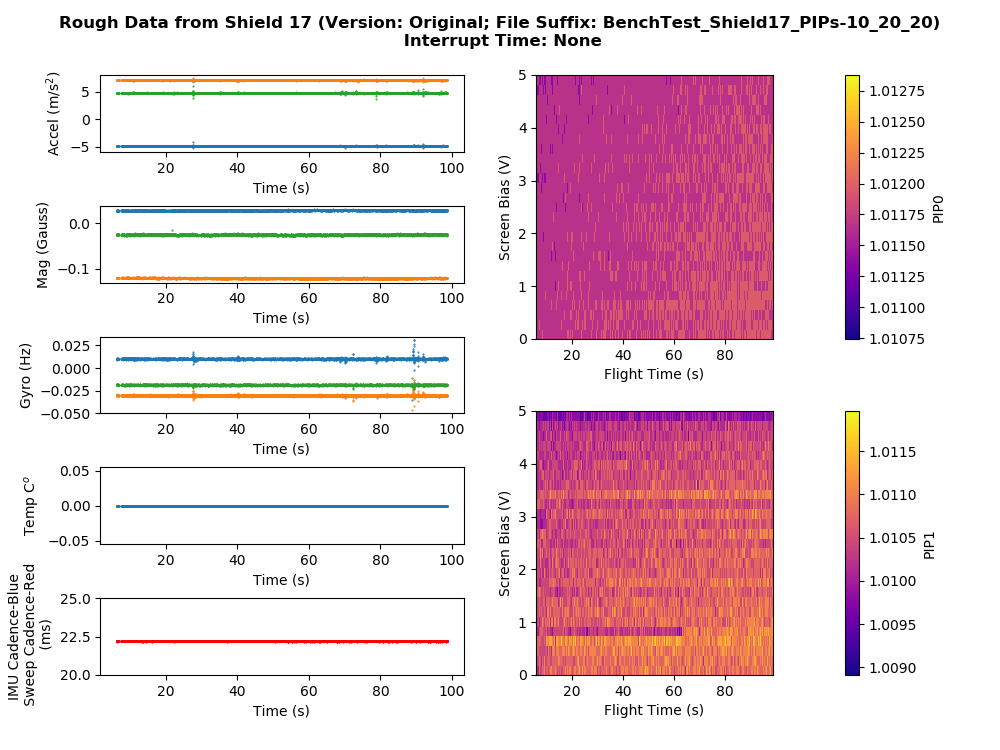

1/7 Done
2/7 Done
3/7 Done
4/7 Done
5/7 Done
6/7 Done
7/7 Done


In [25]:
# Choose whether to have "index" (True) or "Time" (False) as the x axis of the Cadance plot
Cadance_xAx_index=False
# Plot IMU Cadance in space of Temperature plot (True) or on same plot as the Sweep Cadance(False)
sep_Cad=False

fname_info_extra=['strict_parse', 'Cadance_xAx_index', 'sep_Cad']
info_vars=[strict_parse, Cadance_xAx_index, sep_Cad]

#default_plot(**gen_pltdcts(run1, plottype='Original', graph = 'default', add_vars = {'strict_parse': strict_parse, 'sep_Cad': sep_Cad, 'Cadance_xAx_index': Cadance_xAx_index}))

In [22]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division
def default_plot(imuPlot, axPlot, ayPlot, azPlot, gxPlot, gyPlot, gzPlot, mxPlot, myPlot, mzPlot, tempPlot, sweepPlot, pip0Plot, pip1Plot, 
                interruptValue, interruptArray, dataFile, shieldID, plottype, GPS_time, strict_parse, sep_Cad, Cadance_xAx_index):

    dots = True

    gs_left = plt.GridSpec(5, 2,  hspace=0.7)

    # Set up dots or not more cleanly
    line_style = '-'
    if dots:
        line_style = '.'

    markersize = 1

    fig = plt.figure(figsize=(10, 7.5))

    # **plot IMU time vs IMU data**
    axis = fig.add_subplot(gs_left[0,0])
    plt.plot(imuPlot, axPlot, line_style, markersize=markersize) 
    plt.plot(imuPlot, ayPlot, line_style, markersize=markersize)  
    plt.plot(imuPlot, azPlot, line_style, markersize=markersize) 
    plt.ylabel("Accel (m/s$^2$)")
    #plt.ylim([-2, 2])  
    plt.xlim([50,80])
    plt.xticks(visible=True)
    plt.xlabel("Time (s)")
    print ("1/7 Done")

    fig.add_subplot(gs_left[1,0], sharex=axis)
    plt.plot(imuPlot, mxPlot, line_style, markersize=markersize) 
    plt.plot(imuPlot, myPlot, line_style, markersize=markersize)  
    plt.plot(imuPlot, mzPlot, line_style, markersize=markersize) 
    plt.ylabel("Mag (Gauss)")
    #plt.ylim([-0.3, 0.3])                 
    plt.xticks(visible=True)
    plt.xlabel("Time (s)")
    print ("2/7 Done")

    fig.add_subplot(gs_left[2,0], sharex=axis)
    plt.plot(imuPlot, gxPlot, line_style, markersize=markersize) 
    plt.plot(imuPlot, gyPlot, line_style, markersize=markersize)  
    plt.plot(imuPlot, gzPlot, line_style, markersize=markersize) 
    plt.ylabel("Gyro (Hz)")
    #plt.ylim([-0.5, 0.5])                  
    plt.xticks(visible=True)
    plt.xlabel("Time (s)")
    print ("3/7 Done")

    if not sep_Cad: 
        fig.add_subplot(gs_left[3,0], sharex=axis)
        plt.plot(imuPlot, tempPlot, line_style, markersize=markersize)
        #plt.ylim([-1, 1])
        plt.ylabel("Temp C$^o$")
        plt.xlabel("Time (s)")
        print ("4/7 Done")


    if not Cadance_xAx_index:
        if sep_Cad: 
            ax2 = fig.add_subplot(gs_left[3,0])
    #        plt.plot(imuPlot[1:], np.diff(imuPlot), line_style, color='blue', markersize=markersize)
            plt.plot(imuPlot[1:], np.diff(imuPlot)*1E3, line_style, color='blue', markersize=markersize)
            plt.ylabel("IMU Cadence\n (ms)")
            print ("4/7 Done")
            fig.add_subplot(gs_left[4,0], sharex=ax2)
            plt.plot(sweepPlot[1:], np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
            plt.ylabel("Sweep Cadence\n (ms)")
        else: 
            fig.add_subplot(gs_left[4,0])
            plt.plot(imuPlot[1:], np.diff(imuPlot)*1E3, line_style, color='blue', markersize=markersize)
            #plt.plot(imuPlot[1:], np.diff(imuPlot), line_style, color='blue', markersize=markersize)
            plt.plot(sweepPlot[1:], np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
            plt.ylabel("IMU Cadence-Blue\n Sweep Cadence-Red\n (ms)")
        plt.ylim([20,25])
       # plt.ylim([15,50])
        ##plt.ylim([22,24])
        #plt.ylim([10,100])

        #plt.xlim([50,80])
        #plt.xlim([100,140]) #GPS On @ ~120s
        #plt.xlim([200,280]) #GPS Off @ ~240s
        #plt.xlim([300,390]) #GPS On @ ~~345s (some wiggle beforehand)
        #plt.xlim([220,230])
        #plt.ylabel("IMU Cadence-Blue\n Sweep Cadence-Red\n (ms)")
        plt.xlabel("Time (s)")
    else: 
        if sep_Cad:
            ax2 = fig.add_subplot(gs_left[3,0])
           # plt.plot(np.diff(imuPlot), line_style, color='blue', markersize=markersize)
            plt.plot(np.diff(imuPlot)*1E3, line_style, color='blue', markersize=markersize)
            plt.ylabel("IMU Cadence\n (ms)")
            print ("4/7 Done")
            fig.add_subplot(gs_left[4,0], sharex=ax2)
            plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
            plt.ylabel("Sweep Cadence\n (ms)")
        else:
            fig.add_subplot(gs_left[4,0])
            #plt.plot(np.diff(imuPlot), line_style, color='blue', markersize=markersize)
            plt.plot(np.diff(imuPlot)*1E3, line_style, color='blue', markersize=markersize)
            plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
            plt.ylabel("IMU Cadence-Blue\n Sweep Cadence-Red\n (ms)")

        plt.ylim([20,25])
        #plt.xlim([650,1000])
        #plt.xlim([4000,5000])

        plt.xlabel("Index")
    print ("5/7 Done")

    # **Plot sweep time vs sweep data (Color plots)**

    # commands to reorient pip array to match with other axes
    pip0_rot = np.rot90(pip0Plot, k=1, axes=(0, 1))
    pip1_rot = np.rot90(pip1Plot, k=1, axes=(0, 1))

    sweep_voltage = np.linspace(0,5,28)

    line_style = '-'

    ax1 = plt.subplot2grid((4,2),(0,1),rowspan = 2)
    plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', vmin = None, vmax = None)
    #plt.ylim([0,2])
    plt.xlim([sweepPlot[0],sweepPlot[-1]])
    ax1.set_xlabel("Flight Time (s)")
    ax1.set_ylabel("Screen Bias (V)")
    cb = plt.colorbar(pad = 0.2)
    cb.set_label("PIP0")
    print ("6/7 Done")

    ax1 = plt.subplot2grid((4,2),(2,1),rowspan = 2)
    plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', vmin = None, vmax = None)
    #plt.ylim([0,2])
    plt.xlim([sweepPlot[0],sweepPlot[-1]])
    ax1.set_xlabel("Flight Time (s)")
    ax1.set_ylabel("Screen Bias (V)")
    cb = plt.colorbar(pad = 0.2)
    cb.set_label("PIP1")
    print ("7/7 Done")

    # Adjust figure
    fig.subplots_adjust(right=.90)
    fig.subplots_adjust(left=0.10)
    fig.subplots_adjust(top=0.90)
    fig.subplots_adjust(bottom=0.10)
    fig.subplots_adjust(hspace=0.75)

    if interruptValue and len(interruptArray) > 100:
        interruptNum = str(interruptArray[0]) + " seconds"
    else:
        interruptNum = "None"

    ##plt.suptitle("Data from Shield %s (Version: %s)\n Interrupt Time: %s" %(shieldID, plottype, interruptNum), fontweight='bold')
    #plt.suptitle("Data from Shield %s (Version: %s; Strict Parse: %s)\n Interrupt Time: %s" %(shieldID, plottype, strict_parse,interruptNum), fontweight='bold')

    #For Debugging GPS
    #plt.suptitle("Rough Data from Shield %s (Version: %s; Strict Parse: %s; File Suffix: %s)\n Interrupt Time: %s" %(shieldID, plottype, strict_parse, dataFile.split('/')[-1].partition('-')[-1].split('.')[0],interruptNum), fontweight='bold')
    if GPS_time is None: plt.suptitle("Rough Data from Shield %s (Version: %s; File Suffix: %s)\n Interrupt Time: %s" %(shieldID, plottype, dataFile.split('/')[-1].partition('-')[-1].split('.')[0],interruptNum), fontweight='bold')
    else: plt.suptitle("Rough Data from Shield %s (Version: %s; File Suffix: %s)\n Interrupt Time: %s; GPS Started At: %s seconds" %(shieldID, plottype, dataFile.split('/')[-1].partition('-')[-1].split('.')[0],interruptNum, GPS_time), fontweight='bold')
    plt.show()


In [23]:
fname_info_extra=['strict_parse', 'Cadance_xAx_index', 'sep_Cad']
info_vars=[strict_parse, Cadance_xAx_index, sep_Cad]

In [155]:
import os
#path="./Figures/"+plottype+"/"
#if not os.path.exists(path): os.makedirs(path)
#figfname='Plot_%s-shield%s-strict_parse_%s-%s.png'%(plottype, shieldID, strict_parse, dataFile.split('/')[-1].partition('.')[0])
meta_info = {'strict_parse':{True: 'strict_parse', False: 'not_strict_parse'},
             'Cadance_xAx_index': {True: 'xax_default', False: 'xax_allTime'},
            'sep_Cad': {True: 'no_Temp_plt', False:'default_plts'}}
if len(fname_info_extra)>0:
    meta_str=[]
    for meta, var in zip(fname_info_extra, info_vars): 
        meta_str.append(meta_info[meta][var])
    meta_str = '-'+'-'.join(meta_str)
else: meta_str=''

figfname='RoughData_%sPlot-shield%s%s-%s.png'%(plottype, shieldID, meta_str, dataFile.split('/')[-1].partition('.')[0])
fig.savefig(path+figfname)
print("Saved Figure to "+path+figfname)

Saved Figure to ./shield_tests/shield_15/GPS_PulseRate_Test/RoughData_RepeatPlot-shield15-strict_parse-xax_allTime-default_plts-data_file_230k-GPS_Pulse_1a01Hz-10_01_20.png


In [171]:
plt.GridSpec?

In [178]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division
def compare_CadancePlots(pltObj_lst, shieldID, strict_parse, Cadance_xAx_index, sep_Cad, xrng=None, yrng=[20,25]):

    dots = True
    if not sep_Cad: gs_left = plt.GridSpec(2, len(pltObj_lst), hspace = .4, wspace = .7, top=.85) #, wspace=.7) #,  hspace=0.7)

    # Set up dots or not more cleanly
    line_style = '-'
    if dots:
        line_style = '.'

    markersize = 1

    fig = plt.figure(figsize=(10, 7.5))
 #   fig = plt.figure()

    col = 0
    ax_lst = []
    for pltObj in pltObj_lst: 
        axis = fig.add_subplot(gs_left[0, col])
        if not Cadance_xAx_index: 
            plt.plot(pltObj.Original['imuPlot'][1:], np.diff(pltObj.Original['imuPlot'])*1E3, line_style, color='blue', markersize=markersize)
            plt.plot(pltObj.Original['sweepPlot'][1:], np.diff(pltObj.Original['sweepPlot'])*1E3, line_style, color='red', markersize=markersize)
            plt.xlabel('Time (s)')
        else: 
            plt.plot(np.diff(pltObj.Original['imuPlot'])*1E3, line_style, color='blue', markersize=markersize)
            plt.plot(np.diff(pltObj.Original['sweepPlot'])*1E3, line_style, color='red', markersize=markersize)
            plt.xlabel('Index')
        plt.ylabel("Orig. IMU Cadence-Blue\n Orig. Sweep Cadence-Red\n (ms)")
        if pltObj.interruptValue and len(pltObj.interruptArray) > 100:
            interruptNum = str(np.round(pltObj.interruptArray[0], decimals=2)) + " s"
        else: interruptNum = "None"
#        axis.set_title('File Suffix: %s\n Interrupt Time: %s; GPS Started At: %s seconds' % (pltObj.dataFile.split('/')[-1].partition('-')[-1].split('.')[0], interruptNum, pltObj.GPS_time))
        axis.set_title('%s\nInterrupt Time: %s; \n GPS Started At: %s s\nOriginal' % (pltObj.note, interruptNum, pltObj.GPS_time))
        del interruptNum
        ax_lst.append(axis)
        
        axis = fig.add_subplot(gs_left[1, col]) #, sharex=True)
        if not Cadance_xAx_index: 
            plt.plot(pltObj.Repeat['imuPlot'][1:], np.diff(pltObj.Repeat['imuPlot'])*1E3, line_style, color='blue', markersize=markersize)
            plt.plot(pltObj.Repeat['sweepPlot'][1:], np.diff(pltObj.Repeat['sweepPlot'])*1E3, line_style, color='red', markersize=markersize)
            plt.xlabel('Time (s)')
        else: 
            plt.plot(np.diff(pltObj.Repeat['imuPlot'])*1E3, line_style, color='blue', markersize=markersize)
            plt.plot(np.diff(pltObj.Repeat['sweepPlot'])*1E3, line_style, color='red', markersize=markersize)
            plt.xlabel('Index')
        plt.ylabel("RAM IMU Cadence-Blue\n RAM Sweep Cadence-Red\n (ms)")
        axis.set_title('Repeat')
        ax_lst.append(axis)
        col += 1
    
    
    for ax in ax_lst: 
        if xrng is not None: ax.set_xlim(xrng)
        ax.set_ylim(yrng) 

    ##plt.suptitle("Data from Shield %s (Version: %s)\n Interrupt Time: %s" %(shieldID, plottype, interruptNum), fontweight='bold')
    #plt.suptitle("Data from Shield %s (Version: %s; Strict Parse: %s)\n Interrupt Time: %s" %(shieldID, plottype, strict_parse,interruptNum), fontweight='bold')

    #For Debugging GPS
    #plt.suptitle("Rough Data from Shield %s (Version: %s; Strict Parse: %s; File Suffix: %s)\n Interrupt Time: %s" %(shieldID, plottype, strict_parse, dataFile.split('/')[-1].partition('-')[-1].split('.')[0],interruptNum), fontweight='bold')
    #if GPS_time is None: fig.suptitle("Rough Data from Shield %s (Version: %s; File Suffix: %s)\n Interrupt Time: %s" %(shieldID, plottype, dataFile.split('/')[-1].partition('-')[-1].split('.')[0],interruptNum), fontweight='bold')
    #else: 
    fig.suptitle("Rough Data from Shield %s\n " %(shieldID), fontweight='bold')
    fig.show()
    return fig, ax_lst


<IPython.core.display.Javascript object>


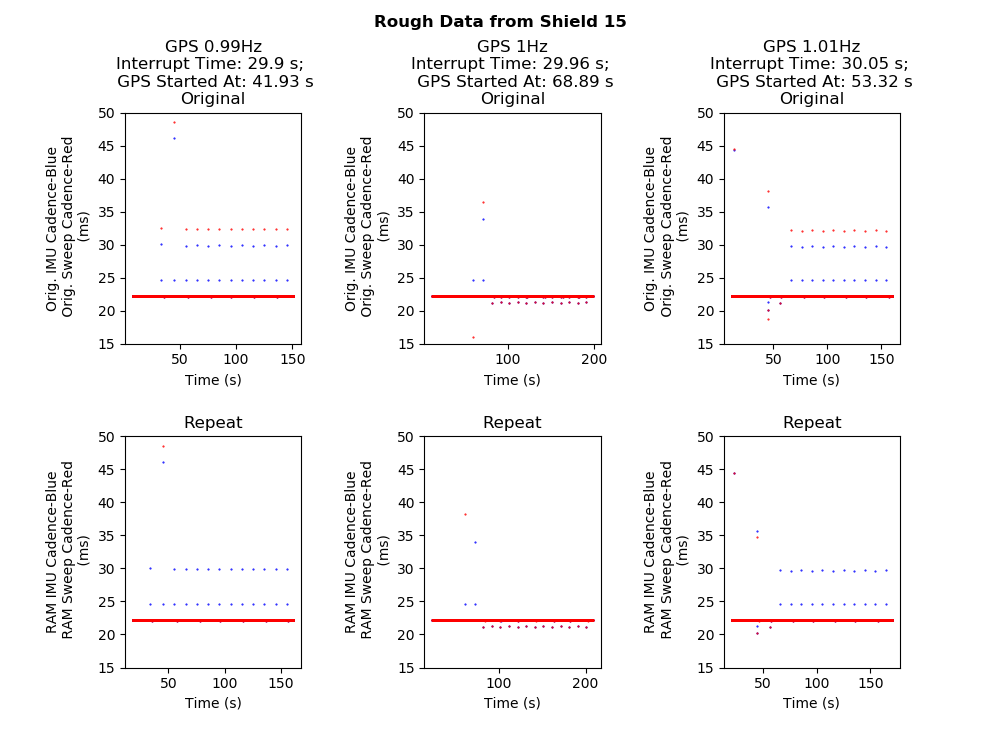

In [179]:

fig, axes = compare_CadancePlots(pltObj_lst=[run1, run2, run3], shieldID=15, strict_parse=True, Cadance_xAx_index=False, sep_Cad=False, xrng=None, yrng=[15,50])
fig.show()

In [180]:
fig.savefig(path+'Compare_Cadances-10_01_2020.png')

In [187]:
imu_cad = np.diff(imuPlot)*1E3
#sweecad = np.diff(sweepPlot)*1E3
print len(imu_cad), len(imuPlot)
#print min(imu_cad), max(imu_cad), np.mean(imu_cad)

6660 6661


In [9]:
dataFile.split('/')#[-1].partition('-')[-1].split('.')[0]

['.',
 'shield_tests',
 'shield_15',
 'GPS_interrupt_post-fix',
 'data_file_230k-Full_Interrupt_Test-09_22_20.txt']

In [15]:
imuPlot[0]

18.806248

In [46]:

dataFile.split('-')[-1].split('.')[0]

Object `split` not found.


In [ ]:
dataFile.split('-')[-1].split

In [48]:
dataFile.partition?